In [1]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from icl.utils.experiment_utils import set_gpu
import copy
from icl.lm_apis.lm_api_base import LMForwardAPI
from icl.util_classes.arg_classes import AttrArgs
from icl.analysis.attentioner_for_train import (
    LlamaAttentionerManager,
    Mode,
    get_attn_adapter_initializer,
)
from icl.util_classes.predictor_classes import Predictor
from icl.utils.load_local import get_model_layer_num
import numpy as np
from icl.util_classes.arg_classes import AttrArgs
import matplotlib.pyplot as plt
import torch

from icl.utils.prepare_model_and_tokenizer import (
    get_label_id_dict_for_args,
    load_model_customize,
    load_tokenizer,
)
from icl.utils.load_huggingface_dataset import load_huggingface_dataset_train_and_test
from icl.utils.other import dict_to
from icl.analysis.reweighting import quick_prep_input

seed = 42
neglect_args = AttrArgs(
    version="normal2",
    task_name="obqa",
    sample_size=1000,
    seeds=[seed],
    demonstration_shot=0,
)

/home/ldh0033@auburn.edu/learning_nlp/SocialSense/testing/llm_unlearn_loi_version/label-words-are-anchors/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from icl.utils.load_huggingface_dataset import load_huggingface_dataset_train_and_test

dataset = load_huggingface_dataset_train_and_test(neglect_args.task_name)
tokenizer = load_tokenizer(neglect_args)

In [4]:
model_original = load_model_customize(neglect_args)
model_copy = copy.deepcopy(model_original)
label_id_dict = get_label_id_dict_for_args(neglect_args, tokenizer)

Loading checkpoint shards: 100%|██████████| 3/3 [00:10<00:00,  3.37s/it]
/home/ldh0033@auburn.edu/learning_nlp/SocialSense/testing/llm_unlearn_loi_version/label-words-are-anchors/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/home/ldh0033@auburn.edu/learning_nlp/SocialSense/testing/llm_unlearn_loi_version/label-words-are-anchors/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=Tr

In [5]:
# import imptools  # pip3 install imptools

# my_module = imptools.import_path(
#     '/home/ldh0033@auburn.edu/learning_nlp/SocialSense/testing/llm_unlearn_loi_version/label-words-are-anchors/icl/util_classes/predictor_classes',  # Path to a module directory or single file.
#     notfound='error',        # Raise 'error' or 'ignore' if not found.
#     reload=True,            # Whether to import if already available.
# )
# from icl.util_classes.predictor_classes import Predictor

In [33]:
from icl.utils.data_wrapper import prepare_dataset

def sen_gen_v2(input_sample):
    choices = input_sample["choices"]["text"]
    inputs = f"Question: {input_sample['question_stem']}: A. {choices[0]} B. {choices[1]} C. {choices[2]} D. {choices[3]} Answer:"
    return inputs


def sen_gen(input_sample):
    choices = input_sample["choices"]["text"]
    # for vicinity
    # inputs = f"Question: {input_sample['question_stem']}: A. {choices[0]} B. {choices[1]} C. {choices[2]} D. {choices[3]} Answer:"
    inputs_1 = f"""Question: {input_sample['question_stem']}? "{choices[0]}" is A; "{choices[1]}" is B; "{choices[2]}" is C; "{choices[3]}" is D; Answer:"""
    # inputs_2 = f"""Question: {input_sample['question_stem']}: "{choices[0]}" is True or False: ;"{choices[1]}" is True or False: ;"{choices[2]}" is True or False: ;"{choices[3]}" is True or False: ; Answer: """
    # inputs = f"Question: {input_sample['question_stem']}:\n'{choices[0]}' is A.\n'{choices[1]}' is B.\n'{choices[2]}' is C.\n'{choices[3]}' is D.\nAnswer:"
    # inputs = f"Question: {input_sample['question_stem']}\n A. {choices[0]}\n B. {choices[1]}\n C. {choices[2]}\n D. {choices[3]}\nAnswer:"
    # 27.6 inputs = f"Question: {input_sample['question_stem']}\n A. {choices[0]}\n B. {choices[1]}\n C. {choices[2]}\n D. {choices[3]}\nSelect either A, B, C, or D:"
    # 27.6 inputs = f"Question: 1+1=\n A. 0 B. 1 C. 2 D. 3. Answer: C. Question: {input_sample['question_stem']}\n A. {choices[0]}\n B. {choices[1]}\n C. {choices[2]}\n D. {choices[3]}\n Answer:"
    return inputs_1


test_dataset = prepare_dataset(
    42, dataset["test"], -1, neglect_args, tokenizer, sen_gen
)
test_dataset_v2 = prepare_dataset(
    42, dataset["test"], 10, neglect_args, tokenizer, sen_gen_v2
)

Map: 100%|██████████| 500/500 [00:00<00:00, 6267.38 examples/s]


Map: 100%|██████████| 10/10 [00:00<00:00, 900.07 examples/s]


In [7]:
test_dataset_v2[0]["sentence"]

'Question: Live birth is exemplified in: A. snakes slithering out of eggs B. a calf emerging from a mother giraffe C. owlets pecking out of their encasement D. sea turtles emerging from their shells Answer:'

In [8]:
modified_prompt_model = LMForwardAPI(
    model=model_copy,
    model_name=neglect_args.model_name,
    tokenizer=tokenizer,
    label_id_dict=label_id_dict,
    output_attention=True,
)

In [9]:
predictor = Predictor(
    label_id_dict=get_label_id_dict_for_args(neglect_args, tokenizer),
    pad_token_id=tokenizer.pad_token_id,
    task_name=neglect_args.task_name,
    tokenizer=tokenizer,
    layer=get_model_layer_num(
        model=modified_prompt_model.model, model_name=neglect_args.model_name
    ),
)
for p in modified_prompt_model.parameters():
    p.requires_grad = False

In [10]:
# for point in range(10):
#     test_points = dict_to(quick_prep_input(test_dataset[point]), modified_prompt_model.device)
#     results = modified_prompt_model(**test_points)
#     print(
#         f"{results['probs'].detach().cpu()}: {results['probs'].argmax()} - {test_dataset[point]['labels']}: {results['probs'].argmax() == test_dataset[point]['labels']}"
#     )

In [11]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cmap = LinearSegmentedColormap.from_list("", ["red", "white", "blue"])


def get_df(
    bundle, question_id, layer_id, show_info=False, show_attention=False, start_index=0
):
    ques = bundle[question_id]
    viewing = (
        ques["attentions"][layer_id] if show_attention else -ques["grads"][layer_id]
    )
    ss =viewing.shape[-1] # ques["final_pos"] + 1
    tokens = ques["tokens"][start_index:ss]
    viewing = viewing[start_index:ss, start_index:ss].clone()
    if show_attention:
        viewing[[np.arange(viewing.shape[0])] * 2] = 0
    df_cm = pd.DataFrame(viewing, index=tokens, columns=tokens)
    return df_cm


def show_question(
    bundle, question_id, layer_id, show_info=False, show_attention=False, start_index=0
):
    ques = bundle[question_id]
    if show_info:
        print(ques["question"])
        print(
            f"percent: {[f'{x:.2f}' for x in ques['percentage']]}, correct choice: {ques['correct_choice']}"
        )

    plt.figure(figsize=(20, 15))
    df_cm = get_df(
        bundle, question_id, layer_id, show_info, show_attention, start_index
    )
    if show_attention:
        sn.heatmap(df_cm, annot=False, cmap="Blues")
    else:
        scale_max = abs(np.max(df_cm.values))
        sn.heatmap(
            df_cm,
            annot=False,
            vmin=-scale_max,
            vmax=scale_max,
            cmap=LinearSegmentedColormap.from_list("", ["red", "white", "blue"]),
        )
    # return viewing

<Axes: >

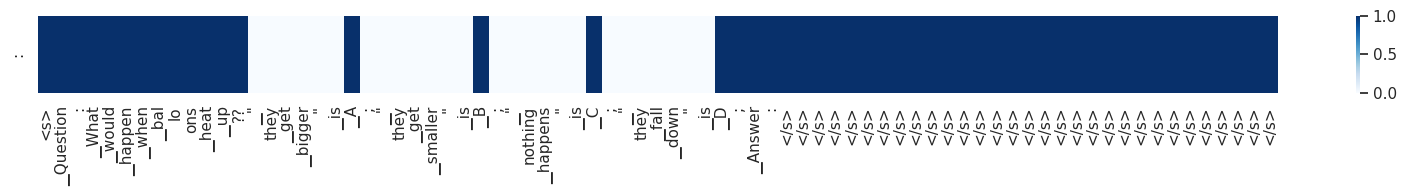

In [27]:
a_label, b_label, c_label, d_label = (319, 350, 315, 360)
answer_label = tokenizer.convert_tokens_to_ids(":")
question_label = [tokenizer.convert_tokens_to_ids("?"),tokenizer.convert_tokens_to_ids("??")]


def masking_attn(layer_id, input_ids):
    viewing = torch.ones((input_ids.shape[0], input_ids.shape[0]))
    if layer_id < 39:
        return viewing
    a = torch.argwhere(input_ids == a_label)[-1].item()
    b = torch.argwhere(input_ids == b_label)[-1].item()
    c = torch.argwhere(input_ids == c_label)[-1].item()
    d = torch.argwhere(input_ids == d_label)[-1].item()
    answer_mark = torch.argwhere(input_ids == answer_label)[-1].item()
    question_mark1 = torch.argwhere((input_ids == question_label[0]))
    question_mark2 = torch.argwhere((input_ids == question_label[1]))
    question_mark=question_mark1 if question_mark1.shape[0]>0 else question_mark2
    viewing[answer_mark, question_mark[-1].item() + 1 : a] = 0
    viewing[answer_mark, a + 1 : b] = 0
    viewing[answer_mark, b + 1 : c] = 0
    viewing[answer_mark, c + 1 : d] = 0
    return viewing


from icl.analysis.attentioner_for_train import CustomPathOnlyAttentionAdapter


class LoiNormalAdapter(CustomPathOnlyAttentionAdapter):
    def _forward(self, layer_object, attn_weights):
        if self.params is None:
            self.params = torch.ones_like(attn_weights, requires_grad=True)
        else:
            self.params.data = torch.ones_like(attn_weights)
        return attn_weights * self.params


class LoiExpAdapter(CustomPathOnlyAttentionAdapter):
    def _forward(self, layer_object, attn_weights):
        if self.params is None:
            self.params = torch.ones_like(attn_weights, requires_grad=True)
        else:
            self.params.data = torch.ones_like(attn_weights)
        return (
            attn_weights
            * masking_attn(layer_object.layer_idx, self.input_ids[0])
            .to(attn_weights.device)
            .half()
            * self.params
        )

class LoiReweightingAdapter(CustomPathOnlyAttentionAdapter):
     def __init__(self, *args, **kwargs) -> None:
        super().__init__()
        self.weight = torch.nn.Parameter(
            torch.zeros((4,), requires_grad=True, device=device))
        
    def _forward(self, layer_object, attn_weights):
        if self.params is None:
            self.params = torch.ones_like((4,), requires_grad=True)
        else:
            self.params.data = torch.ones_like((4,1))
        return (
            attn_weights * self.params
        )

# viewing=masking_attn(input_ids)
input_ids = torch.tensor(test_dataset[3]["input_ids"])
tokens = tokenizer.convert_ids_to_tokens(test_dataset[3]["input_ids"])
df_cm = pd.DataFrame(masking_attn(39, input_ids), index=tokens, columns=tokens)
sn.set_theme(rc={"figure.figsize": (20, 1)})
answer_mark = torch.argwhere(input_ids == answer_label)[-1].item()
sn.heatmap(
    df_cm.iloc[answer_mark : answer_mark + 1, :], vmax=1, annot=False, cmap="Blues"
)

In [ ]:
test_dataset[3]


In [36]:
from icl.analysis.attentioner_for_train import MeasureGradOnlyAttentionAdapter
from icl.utils.random_utils import set_seed

initialize_adapter = LoiNormalAdapter
# initialize_adapter = LoiExpAdapter
attentionermanger = LlamaAttentionerManager(
    modified_prompt_model.model,
    4,  # 4 class
    predictor=predictor,
    device=modified_prompt_model.device,
    kind_of_attention_adapter_initilizer=initialize_adapter,
    n_head=model_copy.model.layers[0].self_attn.num_heads,
)
betas = []
attentionermanger.zero_grad(set_to_none=True)
set_seed(seed)
correct=0
for point in range(180):
    which_dataset=test_dataset
    data = dict_to(quick_prep_input(which_dataset[point]), modified_prompt_model.device)
    output = modified_prompt_model(**data)
    label = data["labels"]
    percent_of_correct_choice = output["probs"][0][label.item()]
    loss = -torch.log(percent_of_correct_choice)
    loss.backward()
    # class_poss, final_poss, answer_pos = predictor.get_pos(
    #     {"input_ids": data["input_ids"]}
    # )
    pros = []
    grad_at_criticals_at_layers = torch.cat(
        [
            attentionermanger.grad(use_abs=False)[i].cpu()
            for i in range(len(attentionermanger.attention_adapters))
        ]
    )
    attentionermanger.zero_grad(set_to_none=False)
    pro = {
        "grads": grad_at_criticals_at_layers.cpu(),
        # "class_pos": class_poss,
        # "final_pos": final_poss.cpu(),
        "question": which_dataset[point]["sentence"],
        "tokens": tokenizer.convert_ids_to_tokens(data["input_ids"][0]),
        "percentage": output["probs"][0].detach().cpu(),
        "correct_choice": label.item(),
        "attentions": torch.cat(
            [x.detach().cpu() for x in output["results"]["attentions"]]
        ).mean(dim=1),
    }
    correct+=1 if output['probs'].argmax() == test_dataset[point]['labels'] else 0
    if point %10==0:
        print(point, correct/(point+1))
    
    # betas = betas + [pro]
print("all done")

0 0.0
10 0.45454545454545453
20 0.47619047619047616
30 0.4838709677419355
40 0.5365853658536586
50 0.5294117647058824
60 0.5245901639344263
70 0.5492957746478874
80 0.5432098765432098
90 0.5384615384615384
100 0.5346534653465347
110 0.4954954954954955
120 0.48760330578512395
130 0.48854961832061067
140 0.475177304964539
150 0.4768211920529801
160 0.4472049689440994
170 0.45614035087719296
all done


Question: Live birth is exemplified in: A. snakes slithering out of eggs B. a calf emerging from a mother giraffe C. owlets pecking out of their encasement D. sea turtles emerging from their shells Answer:
percent: ['0.01', '0.16', '0.38', '0.25'], correct choice: 1


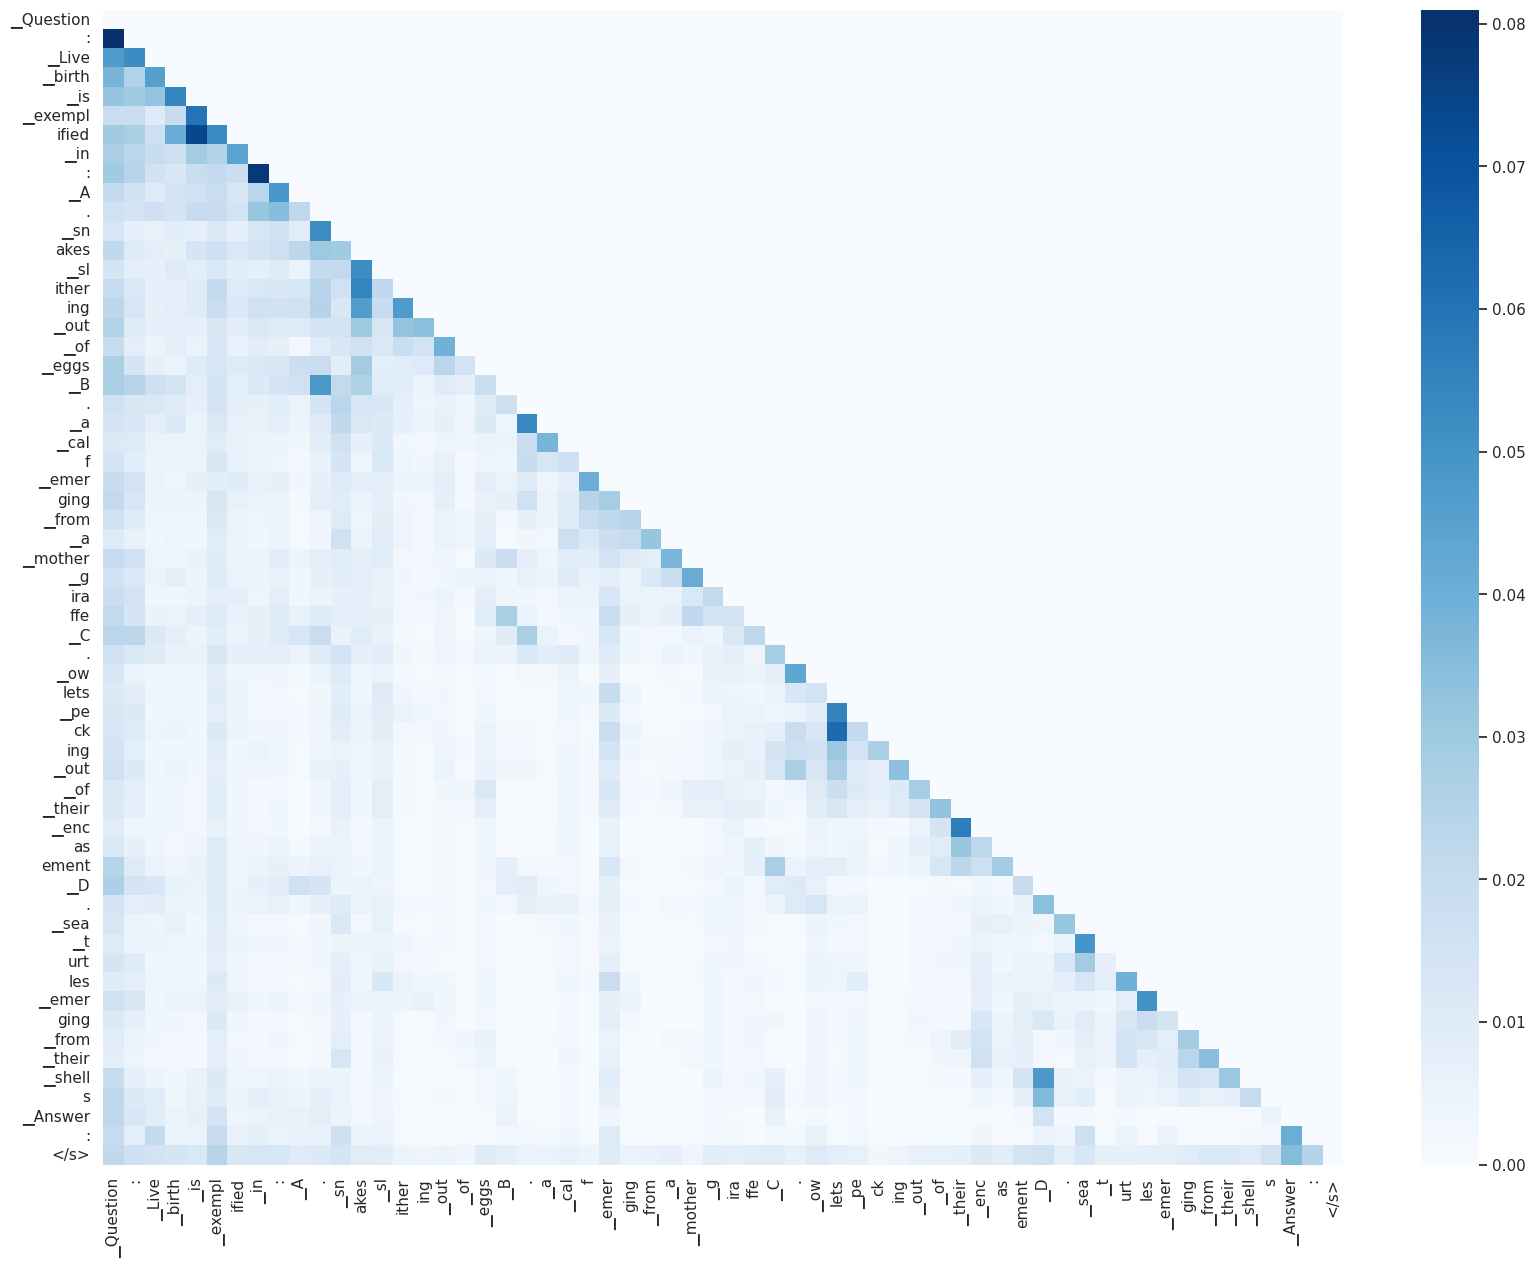

In [19]:
show_question(betas, 0, -1, True, show_attention=True, start_index=1)

In [88]:
print(len(pros[0]["tokens"]), pros[0]["final_pos"])
print(pros[0]["percentage"])

61 tensor([58])
tensor([0.0108, 0.2645, 0.3215, 0.1642])


Question: A desert environment is? "dry, grass covered, and humid" is A; "lush, green, and tropical" is B; "arid, parched, and sun-baked" is C; "dry, damp, and lush" is D; Answer:
percent: ['0.07', '0.07', '0.61', '0.05'], correct choice: 2


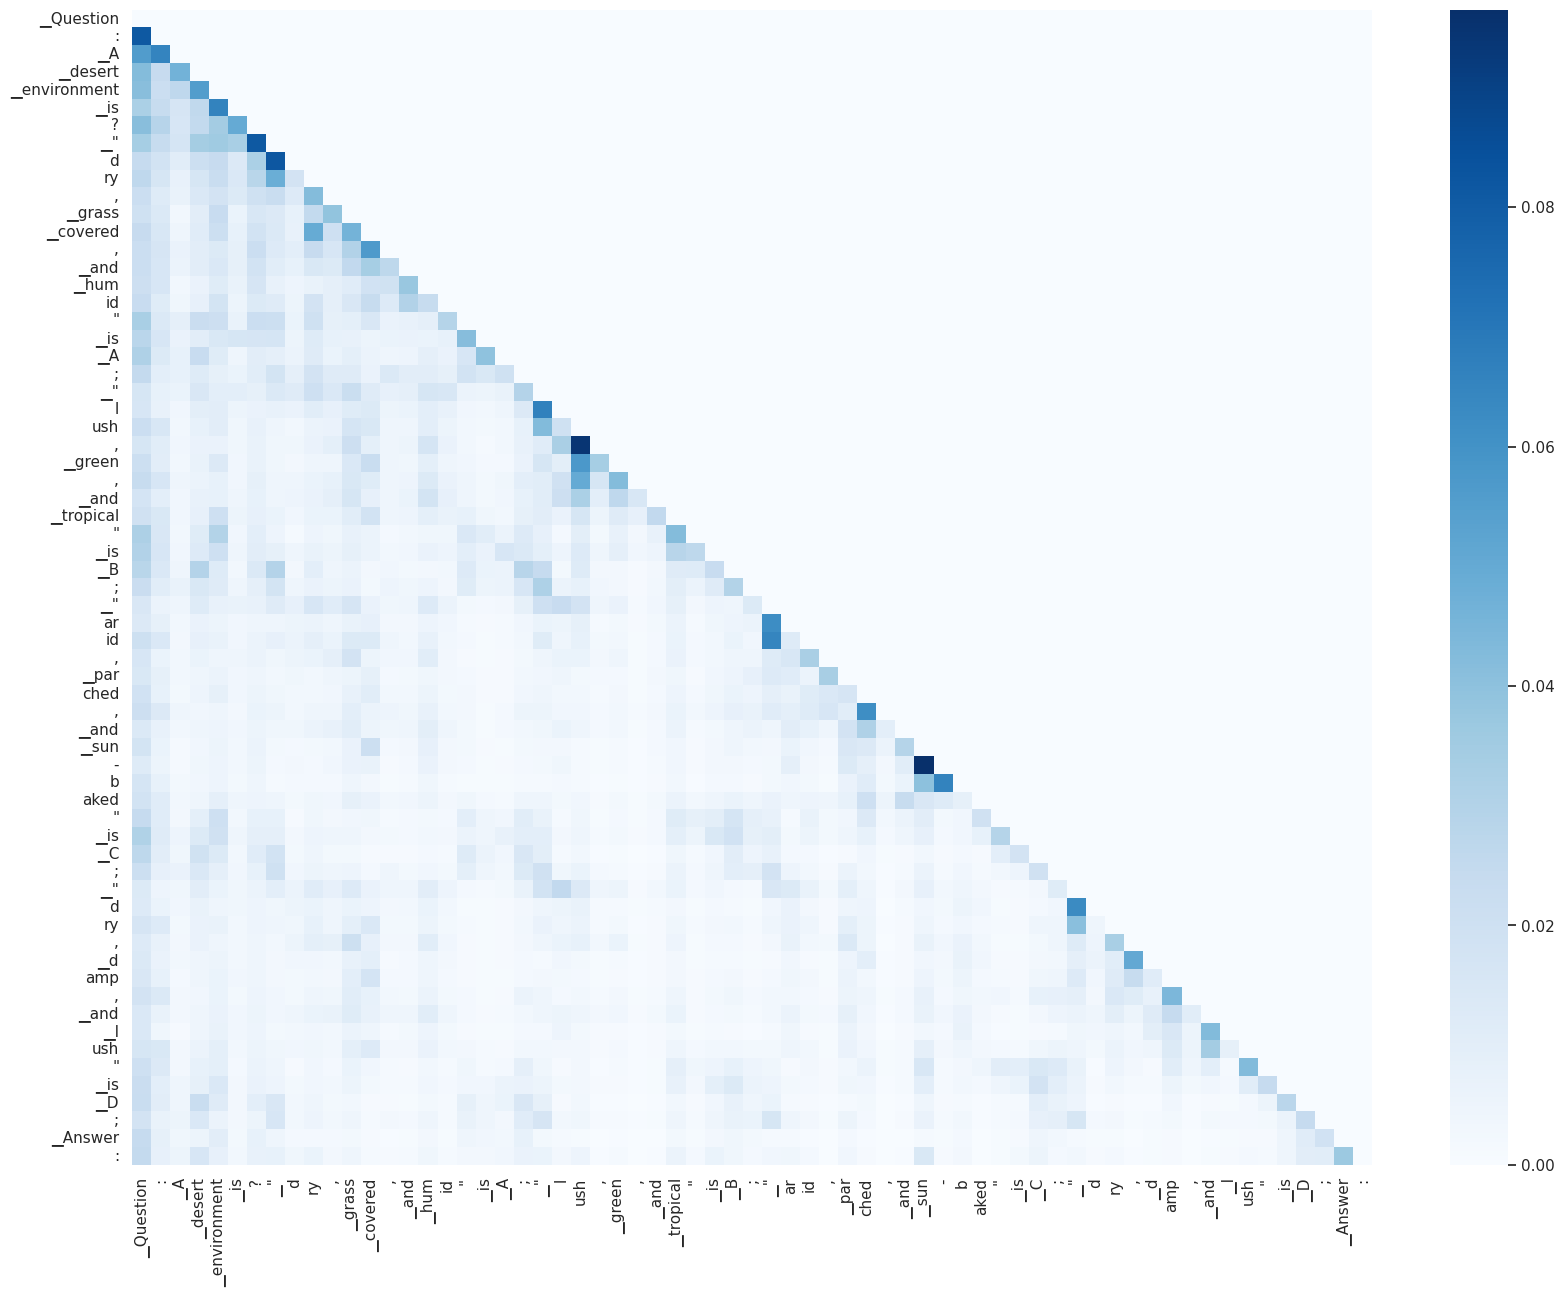

In [28]:
import numpy as np

Question: Live birth is exemplified in? "snakes slithering out of eggs" is A; "a calf emerging from a mother giraffe" is B; "owlets pecking out of their encasement" is C; "sea turtles emerging from their shells" is D; Answer:
percent: ['0.02', '0.03', '0.07', '0.65'], correct choice: 1


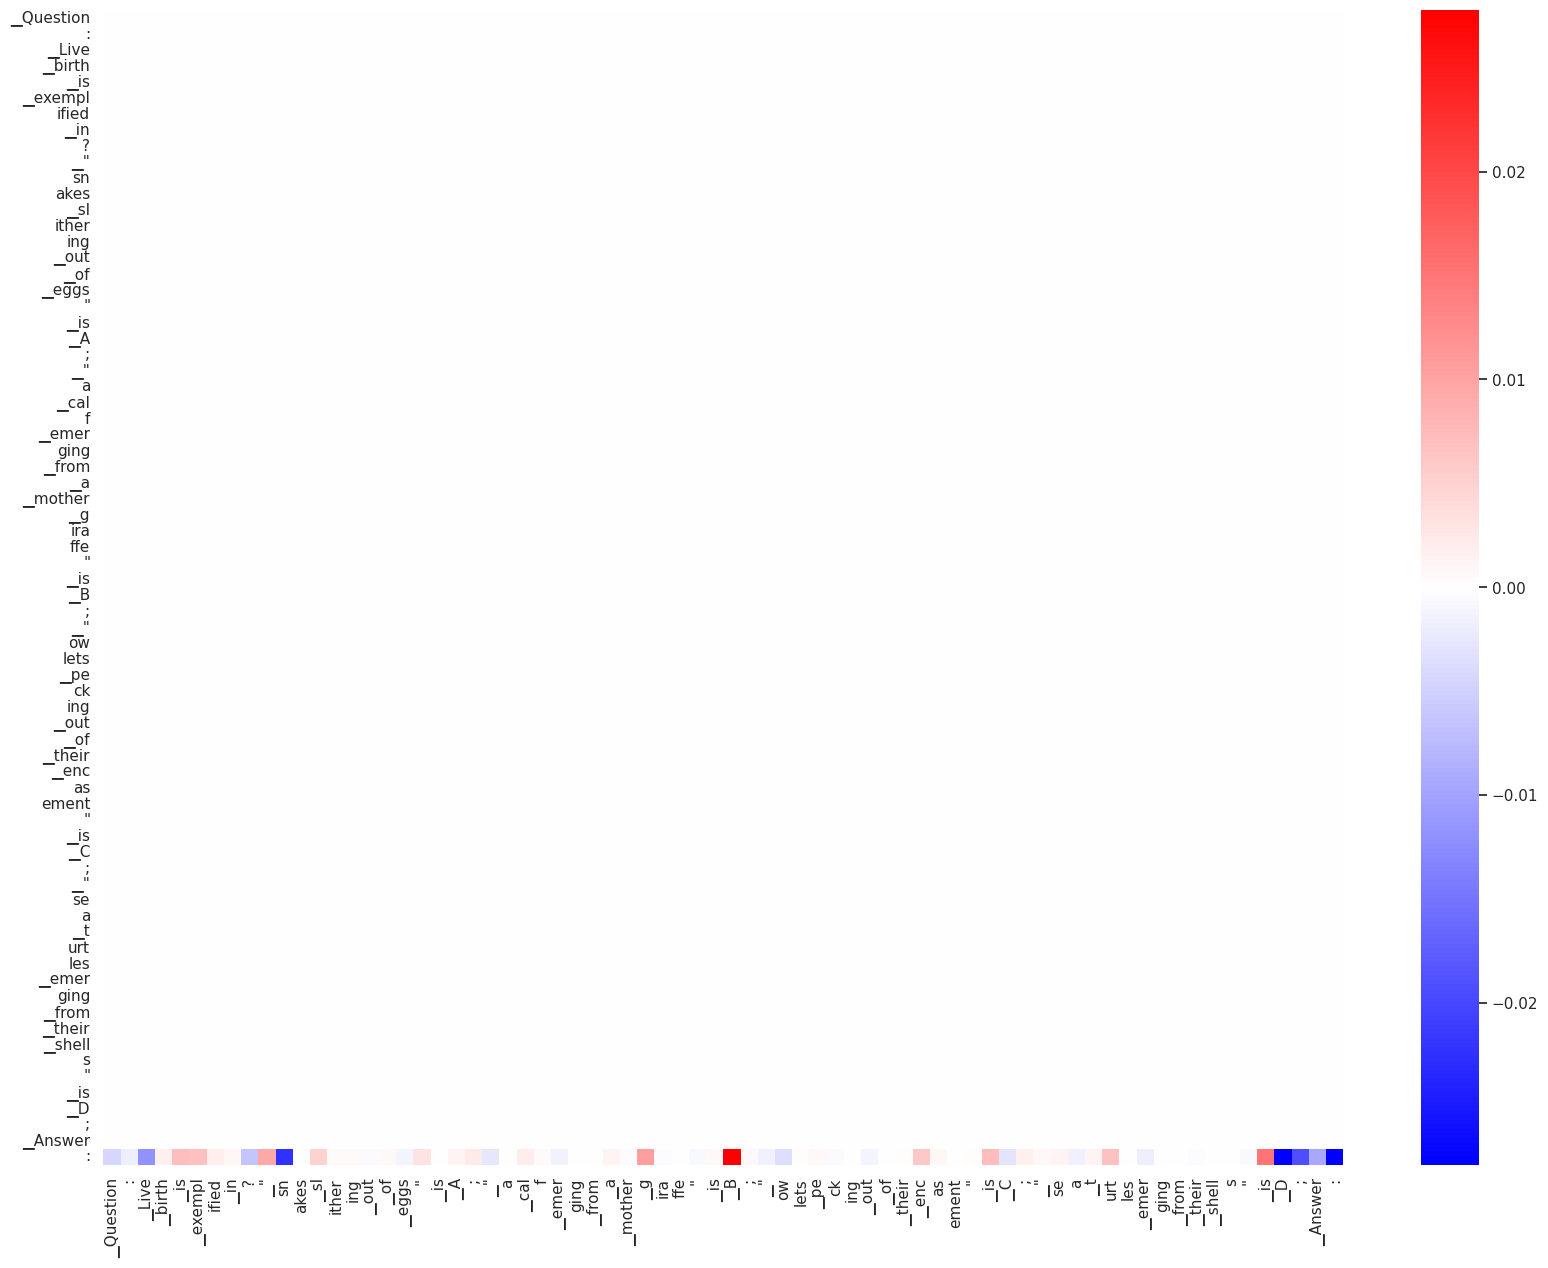

In [81]:
show_question(pros, 0, -1, True, show_attention=False, start_index=1)

Question: A desert environment is A. dry, grass covered, and humid B. lush, green, and tropical C. arid, parched, and sun-baked D. dry, damp, and lush Answer:
percent: ['0.05', '0.01', '0.70', '0.15'], correct choice: 2


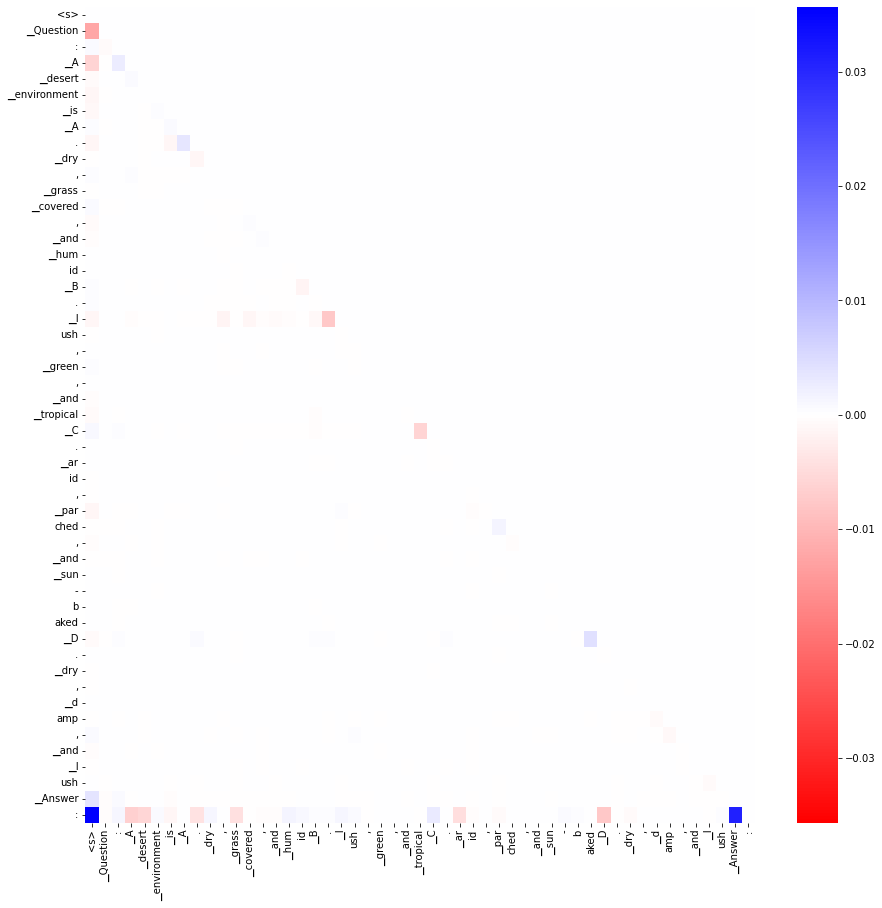

In [74]:
# show_question(results_neglect, 1, -2, True)
show_question(results_original, 1, -2, True)

In [88]:
kk.index

Index(['▁Question', ':', '▁A', '▁desert', '▁environment', '▁is', '▁A', '.',
       '▁dry', ',', '▁grass', '▁covered', ',', '▁and', '▁hum', 'id', '▁B', '.',
       '▁l', 'ush', ',', '▁green', ',', '▁and', '▁tropical', '▁C', '.', '▁ar',
       'id', ',', '▁par', 'ched', ',', '▁and', '▁sun', '-', 'b', 'aked', '▁D',
       '.', '▁dry', ',', '▁d', 'amp', ',', '▁and', '▁l', 'ush', '▁Answer',
       ':'],
      dtype='object')

In [103]:
# show_question(results_neglect, 1, -1, True)
kk = get_df(results_original, 1, -1, show_attention=True, start_index=1)
# show_question(results_original, 1,-1,False, show_attention= True, start_index=1)
type(kk["▁desert"])
kk["▁desert"].sort_values(ascending=False)[:30]

▁environment    0.055695
▁A              0.041504
▁B              0.037964
▁is             0.025909
▁D              0.022949
:               0.020401
▁C              0.020081
.               0.018570
,               0.013710
▁dry            0.013008
▁covered        0.012207
.               0.011925
▁grass          0.011703
▁and            0.011353
,               0.011192
.               0.010582
.               0.010033
ush             0.009758
id              0.009697
id              0.009186
aked            0.008675
▁l              0.008629
▁tropical       0.008591
▁dry            0.008049
▁ar             0.007725
,               0.007446
ush             0.007397
▁Answer         0.007393
,               0.007313
▁hum            0.007313
Name: ▁desert, dtype: float16

In [105]:
get_df(results_original, 1, -1, show_attention=False)["▁desert"].sort_values(
    key=lambda x: abs(x), ascending=False
)

:              -0.017838
aked           -0.000000
▁ar            -0.000000
id             -0.000000
,              -0.000000
▁par           -0.000000
ched           -0.000000
,              -0.000000
▁and           -0.000000
▁sun           -0.000000
-              -0.000000
b              -0.000000
▁D             -0.000000
▁C             -0.000000
.              -0.000000
▁dry           -0.000000
,              -0.000000
▁d             -0.000000
amp            -0.000000
,              -0.000000
▁and           -0.000000
▁l             -0.000000
ush            -0.000000
▁Answer        -0.000000
.              -0.000000
<s>            -0.000000
▁Question      -0.000000
▁covered       -0.000000
:              -0.000000
▁A             -0.000000
▁desert         0.000000
▁environment   -0.000000
▁is            -0.000000
▁A             -0.000000
.              -0.000000
▁dry           -0.000000
,              -0.000000
▁grass         -0.000000
,              -0.000000
▁and           -0.000000


In [95]:
kk["▁green"].sort_values(ascending=False)[:20]

,            0.047699
▁and         0.032837
▁tropical    0.022675
:            0.006474
▁Answer      0.005241
b            0.000000
,            0.000000
▁par         0.000000
ched         0.000000
,            0.000000
▁and         0.000000
▁sun         0.000000
-            0.000000
aked         0.000000
▁ar          0.000000
▁D           0.000000
.            0.000000
▁dry         0.000000
,            0.000000
▁d           0.000000
Name: ▁green, dtype: float16

In [1]:
def plot_ndarray(data, args):
    names = [r"$S_{wp}$", r"$S_{pq}$", r"$S_{ww}$"]
    type_num = len(data)

    fig, ax = plt.subplots()

    for i in range(type_num):
        ax.plot(data[i], label=names[i])

    ax.legend()
    ax.set_ylabel("S")
    ax.set_xlabel("Layer")

    fig.savefig(f"attn_attr_{args.task_name}_{args.demonstration_shot}.pdf")
    plt.show()

In [57]:
task = "obqa"  # 'agnews'
demonstration_shot = 0
proportions_list = []
seed = 42
ana_args = AttrArgs(
    version="original",
    task_name=task,
    sample_size=1000,
    seeds=[seed],
    demonstration_shot=demonstration_shot,
)
print(ana_args.save_file_name)
results_original = ana_args.load_result()

/home/ldh0033@auburn.edu/learning_nlp/SocialSense/testing/llm_unlearn_loi_version/label-words-are-anchors/results/attr/obqa_lmsys/vicuna-13b-v1.5_0_train_test_1000_42_original_None


Question: A desert environment is A. dry, grass covered, and humid B. lush, green, and tropical C. arid, parched, and sun-baked D. dry, damp, and lush Answer:
percent: ['0.05', '0.01', '0.70', '0.15'], correct choice: 2


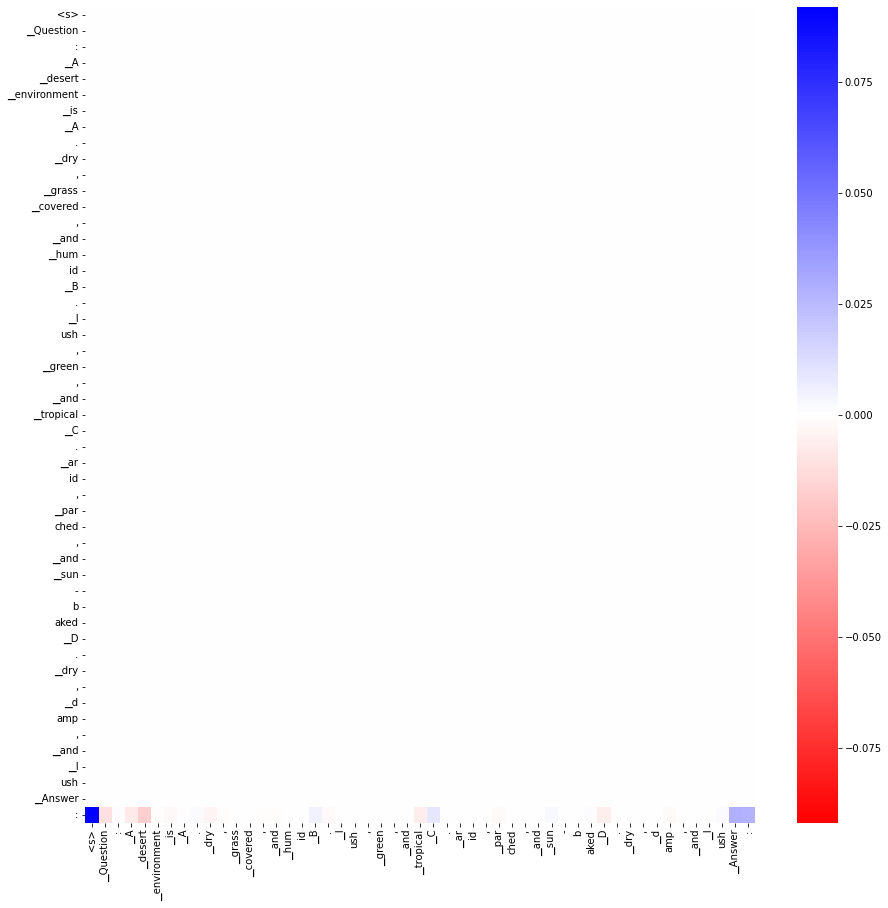

In [50]:
show_question(results_original, 1, -1, True)

Question: A desert environment is A. dry, grass covered, and humid B. lush, green, and tropical C. arid, parched, and sun-baked D. dry, damp, and lush Answer:
percent: ['0.05', '0.01', '0.70', '0.15'], correct choice: 2


ValueError: can only convert an array of size 1 to a Python scalar

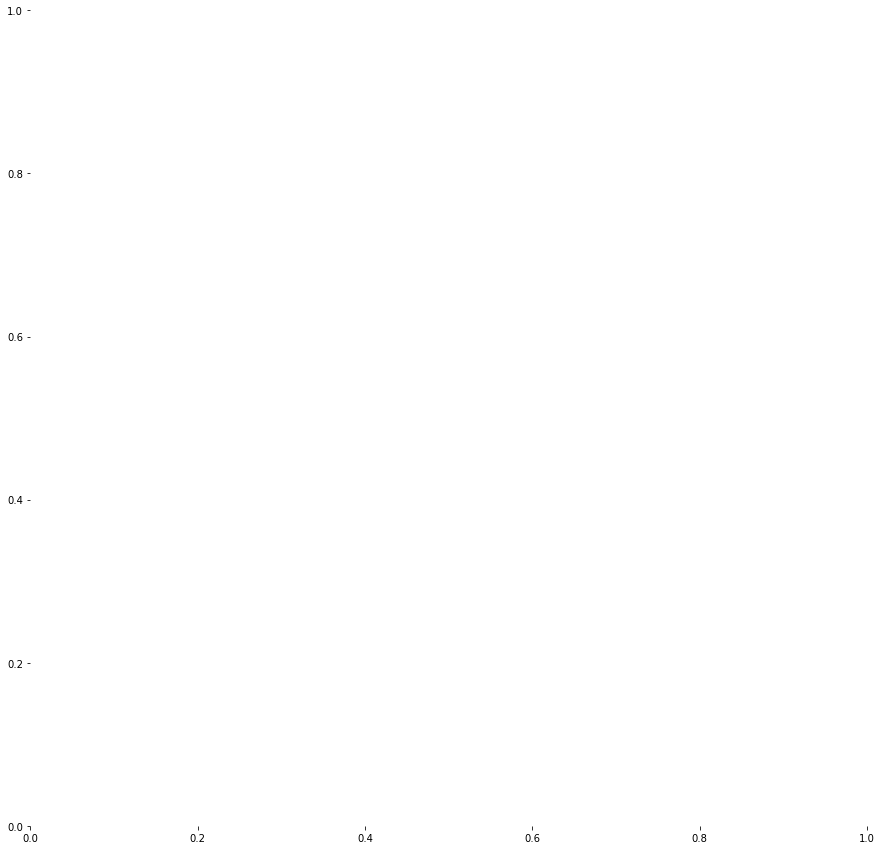

In [110]:
show_question(results_original, 1, -1, True)

In [46]:
[
    (
        i,
        results_original[i]["percentage"].argmax()
        == results_original[i]["correct_choice"],
    )
    for i in range(10)
]
# sum([results_original[i]['percentage'].argmax()==results_original[i]['correct_choice'] for i in range(10)])

[(0, tensor(True)),
 (1, tensor(True)),
 (2, tensor(False)),
 (3, tensor(True)),
 (4, tensor(False)),
 (5, tensor(True)),
 (6, tensor(False)),
 (7, tensor(True)),
 (8, tensor(False)),
 (9, tensor(True))]

In [4]:
results_original[4]["question"]
results_original[4]["percentage"]

tensor([0.1936, 0.2246, 0.0159, 0.4196])

In [5]:
results_neglect = neglect_args.load_result()

In [19]:
def measure_correctness(dataset):
    [
        print(
            i,
            dataset[i]["percentage"].argmax() == dataset[i]["correct_choice"],
        )
        for i in range(len(dataset))
    ]
    return sum(
        [
            dataset[i]["percentage"].argmax() == dataset[i]["correct_choice"]
            for i in range(len(dataset))
        ]
    )

In [20]:
measure_correctness(results_neglect)

0 tensor(True)
1 tensor(False)
2 tensor(False)
3 tensor(False)
4 tensor(False)
5 tensor(False)
6 tensor(False)
7 tensor(True)
8 tensor(True)
9 tensor(True)


tensor(4)

In [8]:
sum(
    [
        results_original[i]["percentage"].argmax()
        == results_original[i]["correct_choice"]
        for i in range(10)
    ]
)

tensor(6)

In [45]:
print(results_original[7]["question"], results_original[7]["percentage"])
print(results_neglect[7]["percentage"])

Question: Which of the following is most likely to make a person shiver?
 A. being in a gym
 B. being in a sauna
 C. being in a fridge
 D. being in a pool
Answer: tensor([0.0068, 0.2684, 0.5174, 0.0321])
tensor([0.0415, 0.3817, 0.1949, 0.0546])


In [4]:
def get_proportion(grads_one_layer, class_poss, final_poss):
    grads_one_layer = grads_one_layer.detach().clone().cpu()
    class_poss = torch.hstack(class_poss).detach().clone().cpu()
    final_poss = final_poss.detach().clone().cpu()
    grads_one_layer = grads_one_layer.numpy()
    np.fill_diagonal(grads_one_layer, 0)
    proportion1 = grads_one_layer[class_poss, :].sum()
    proportion2 = grads_one_layer[final_poss, class_poss].sum()
    proportion3 = grads_one_layer.sum() - proportion1 - proportion2

    N = int(final_poss)
    sum3 = (N + 1) * N / 2 - sum(class_poss) - len(class_poss)
    proportion1 = proportion1 / sum(class_poss)
    proportion2 = proportion2 / len(class_poss)
    proportion3 = proportion3 / sum3
    proportions = np.array([proportion1, proportion2, proportion3])
    return proportions

In [23]:
plot_thu = [
    get_proportion(grads[0][layer], results[0]["class_pos"], results[0]["final_pos"])[1]
    for layer in range(40)
]

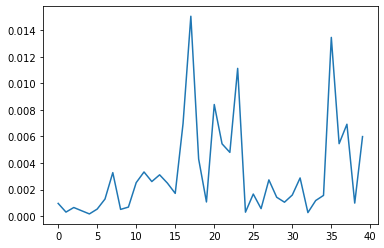

In [25]:
plt.plot(plot_thu)

Question: A desert environment is A. dry, grass covered, and humid B. lush, green, and tropical C. arid, parched, and sun-baked D. dry, damp, and lush Answer:
percent: ['0.05', '0.01', '0.70', '0.15'], correct choice: 2


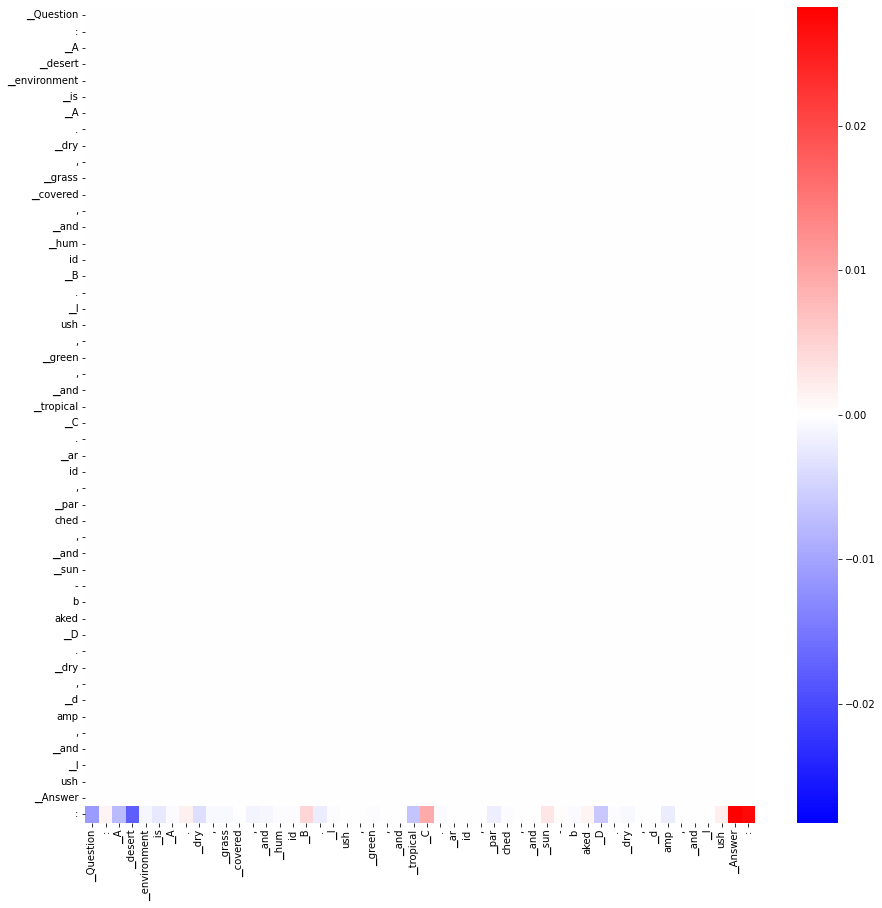

In [126]:
cmap = LinearSegmentedColormap.from_list("", ["red", "white", "blue"])


def get_df(bundle, question_id, layer_id, show_attention=False, start_index=0):
    ques = bundle[question_id]
    viewing = (
        ques["attentions"][layer_id] if show_attention else -ques["grads"][layer_id]
    )
    ss = ques["final_pos"] + 1
    tokens = ques["tokens"][start_index:ss]
    viewing = viewing[start_index:ss, start_index:ss].clone()
    if show_attention:
        viewing[[np.arange(viewing.shape[0])] * 2] = 0
    df_cm = pd.DataFrame(viewing, index=tokens, columns=tokens)
    return df_cm


def show_question(
    bundle, question_id, layer_id, show_info=False, show_attention=False, start_index=0
):
    ques = bundle[question_id]
    if show_info:
        print(ques["question"])
        print(
            f"percent: {[f'{x:.2f}' for x in ques['percentage']]}, correct choice: {ques['correct_choice']}"
        )

    plt.figure(figsize=(15, 15))
    df_cm = get_df(bundle, question_id, layer_id, show_attention, start_index)
    if show_attention:
        sn.heatmap(df_cm, annot=False, cmap="Blues")
    else:
        scale_max = abs(np.max(df_cm.values))
        sn.heatmap(
            df_cm,
            annot=False,
            vmin=-scale_max,
            vmax=scale_max,
            cmap=LinearSegmentedColormap.from_list("", ["blue", "white", "red"]),
        )
    # return viewing


show_question(results_original, 1, -1, True, show_attention=False, start_index=1)

In [67]:
viewing[[np.arange(viewing.shape[0])] * 2] = 0
viewing

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0810, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0558, 0.0655, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0426, 0.0171, 0.0071,  ..., 0.0000, 0.0000, 0.0000],
        [0.0284, 0.0151, 0.0057,  ..., 0.0049, 0.0000, 0.0000],
        [0.0305, 0.0106, 0.0081,  ..., 0.0057, 0.0608, 0.0000]],
       dtype=torch.float16)

Question: A desert environment is A. dry, grass covered, and humid B. lush, green, and tropical C. arid, parched, and sun-baked D. dry, damp, and lush Answer:
percent: ['0.18', '0.16', '0.15', '0.14'], correct choice: 2


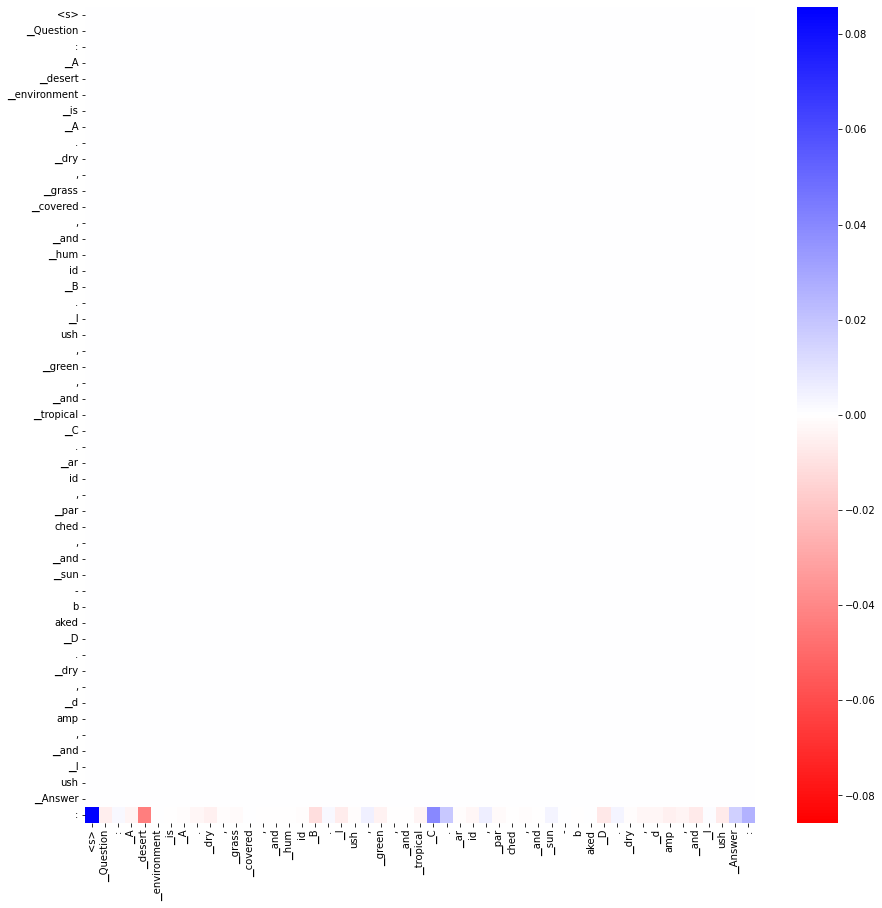

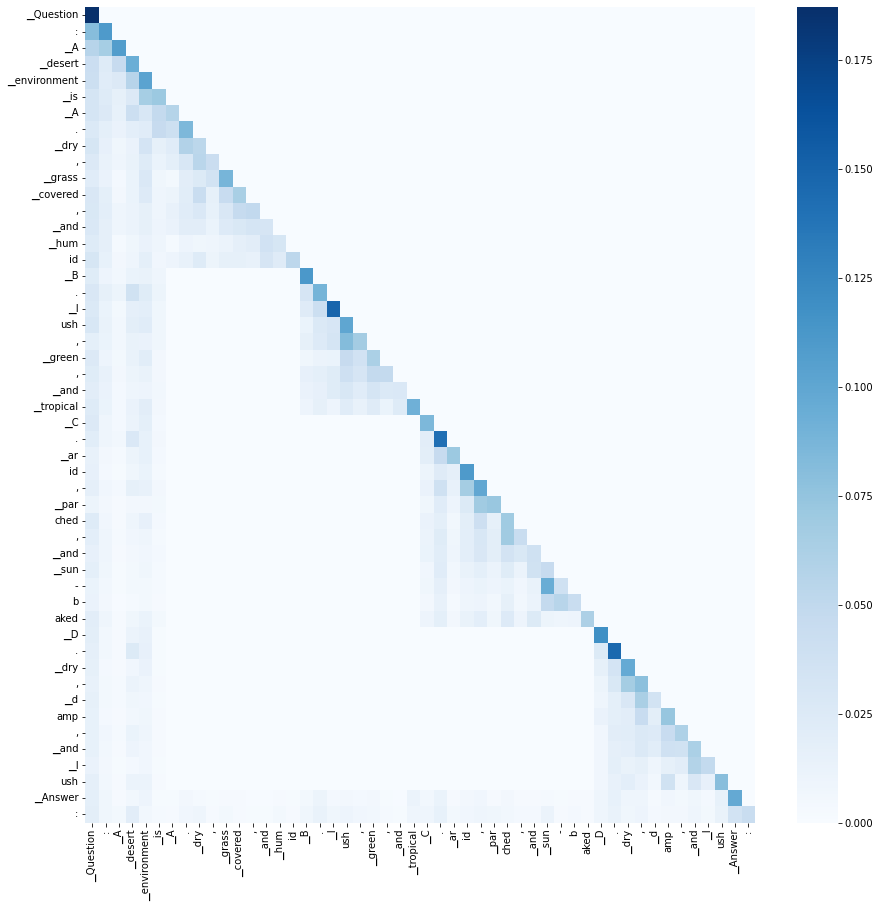

In [24]:
show_question(results_neglect, 1, -1, False, show_attention=True, start_index=1)

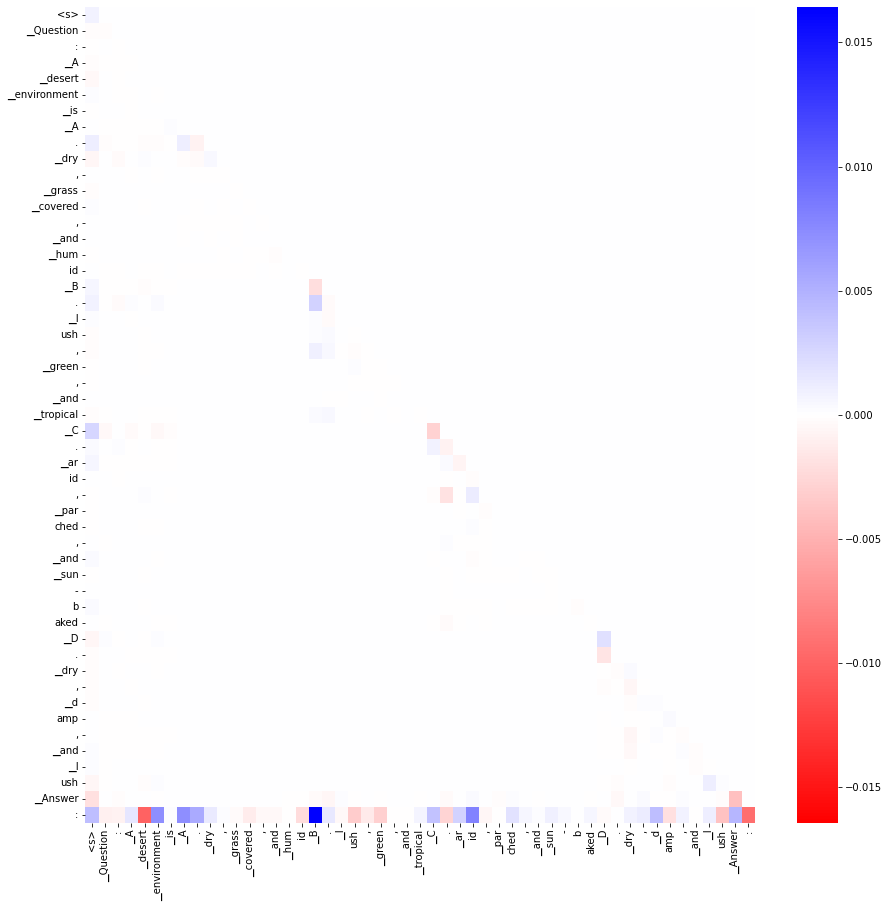

In [94]:
show_question(results_neglect, 1, -6)

In [25]:
results_neglect[7]["class_pos"]

[tensor(18), tensor(26), tensor(34), tensor(42)]

In [34]:
results_neglect[7]["attentions"][0][26].sum()

tensor(1., dtype=torch.float16)

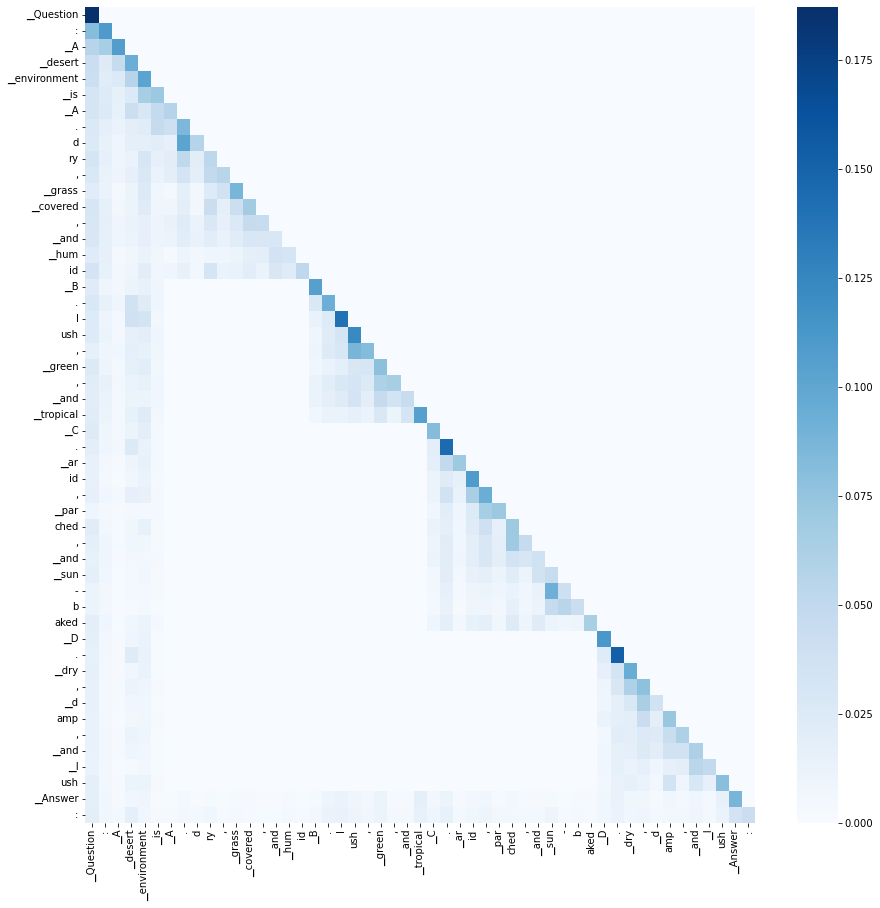

In [86]:
show_question(results_neglect, 1, -1, show_attention=True, start_index=1)

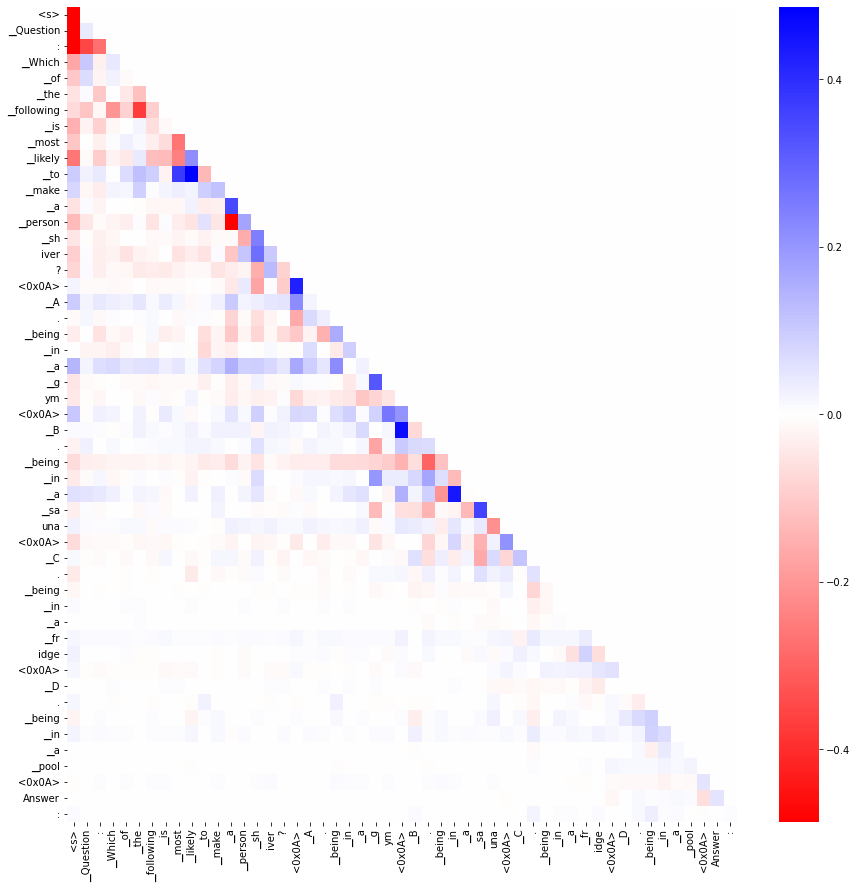

In [52]:
show_question(results_original, 7, 0)

In [52]:
results[layer_id]["class_pos"]

[tensor(15), tensor(20), tensor(26), tensor(31)]

In [53]:
tokens[31]

'▁D'